In [3]:
import pandas as pd, numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import datetime

### Import dataset

In [4]:
train= pd.read_csv('../data/train.csv')
store= pd.read_csv('../data/store.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


It turns out that there ars some null values in the store dataset.

#### Lowercase Column Names

In [5]:
train.columns = [col.lower() for col in train.columns]

In [6]:
store.columns = [col.lower() for col in store.columns]

#### Average Sales 

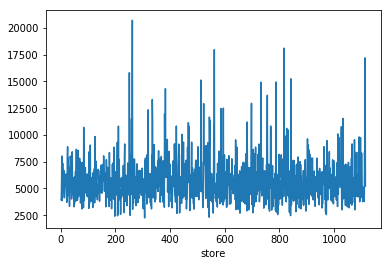

In [7]:
train.groupby('store').mean()['sales'].plot()

It turns out that the average sales gap among the stores can be massive. Why does this happen? It might be because the stores might have different sizes, different promo, the distance to competitors might be far, or customers prefer the company in general.

#### Average customer sales

In [8]:
per_customer= pd.DataFrame(train.groupby(by = 'store').sum()['sales']/train.groupby(by = 'store').sum()['customers'])

In [9]:
per_customer.columns= ['avg_customer_sales']

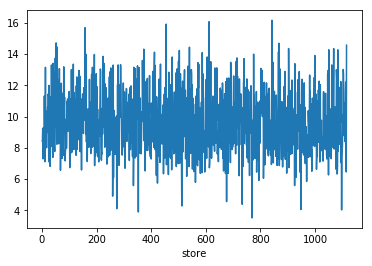

In [10]:
per_customer.avg_customer_sales.plot()

Similarly, expenditures between customer on average seem to have large gaps from stores to stores. In some stores, it turns out that customers tend to spend about 4, while some customers spend over 15 in some stores. However, it does not neccessarlily have the same pattern as average total sales based on stores. 

### Impute null values

In [11]:
store.isnull().sum()

store                          0
storetype                      0
assortment                     0
competitiondistance            3
competitionopensincemonth    354
competitionopensinceyear     354
promo2                         0
promo2sinceweek              544
promo2sinceyear              544
promointerval                544
dtype: int64

There are some missing values in store dataset. 

In [12]:
store[store.promo2 == 0][['promo2sinceweek', 'promo2sinceyear']].sum(axis= 0)

promo2sinceweek    0.0
promo2sinceyear    0.0
dtype: float64

It turns out that if promo2 is 0, promo2sinceweek and promo2sinceyear are encoded as null values. 

In [13]:
store.promo2sinceweek.fillna(0.0, inplace= True)

Missing values in promo2sinceweek are imputed as 0 since promo2 did not happen.

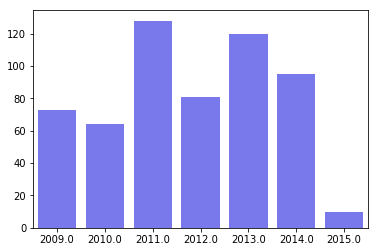

In [14]:
sns.barplot(store.promo2sinceyear.value_counts().index, 
            store.promo2sinceyear.value_counts().values, 
            color= 'b', 
            alpha= 0.6);

In [15]:
store.promo2sinceyear.fillna(2012.0, inplace= True)

Since it is impossible to impute null values as 0 in this case, I will impute the median.

In [16]:
store[store.promointerval.isnull()]['promo2'].value_counts()

0    544
Name: promo2, dtype: int64

In [17]:
store.promointerval.fillna('N/A', inplace= True)

For the same reason, if promo2 is 0, all the values in promo interval are encoded as null values. Therefore, I will impute the values as N/A, so that I know promo 2 did not happen.

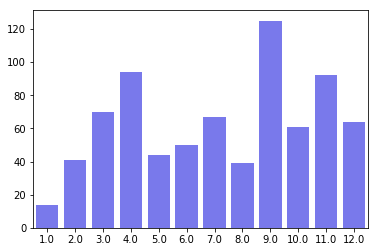

In [18]:
sns.barplot(store.competitionopensincemonth.value_counts().index, 
            store.competitionopensincemonth.value_counts().values, 
            color= 'b', 
            alpha= 0.6);

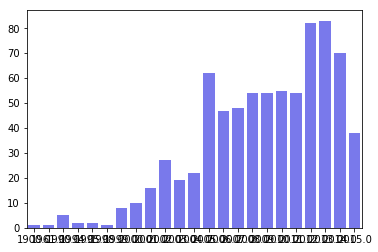

In [19]:
sns.barplot(store.competitionopensinceyear.value_counts().index, 
            store.competitionopensinceyear.value_counts().values, 
            color= 'b', 
            alpha= 0.6);

In [20]:
store.competitiondistance.fillna(store.competitiondistance.mean(), inplace= True)
store.competitionopensincemonth.fillna(store.competitionopensincemonth.median(), inplace= True)
store.competitionopensinceyear.fillna(store.competitionopensinceyear.median(), inplace= True)

Based on the histograms above, I impute missing values in competitiondistance with the mean, in competitionopensincemonth with the media, and in competitionopensinceyear with the median.

In [21]:
store.to_csv('../assets/clean_store.csv')

#### Merging data 

In [22]:
df= pd.merge(train, store, how= 'inner')

Merge data based on stores

#####  State holidays

In [23]:
df['stateholiday'] = df['stateholiday'].astype('object')

In [24]:
df['stateholiday'].replace(0, '0', inplace= True)

There are two values that are essential same, but they are encoded in a different way, therefore, I replace values, so that I can have the same value.

### Export the data

In [25]:
df.to_csv('../assets/clean_df.csv')

##### Set Date as index

In [26]:
df['date'] = pd.to_datetime(df['date'])
df.set_index(df['date'],inplace=True)

In [27]:
df.drop(columns='date',inplace=True)

In [28]:
df.to_csv('../assets/date_df.csv')

###### New features with date 

In [29]:
df['year']= df.index.year
df['month']= df.index.month
df['quarter']= df.index.quarter
df['week']= df.index.week
df['day']= df.index.weekday
df['date'] = df.index.day

###### Average Customer Expenditure

In [30]:
df['per_customer']= df['sales']/df['customers']

I create a new feature called per_customer, which indicates an average customer expenditure based on stores. It will be informative to know that which stores have a higher number of average sales per customer.

In [31]:
df[df['per_customer'].isnull()]['sales'].value_counts()

0    172869
Name: sales, dtype: int64

It turns out that all the null values are occurred because stores have 0 sale on the day. Therefore, it makes sense to impute null values as 0.

In [32]:
df['per_customer'].fillna(0.0, inplace= True)

By setting date as index, it will be easier for me to analyze my data.

In [33]:
df.drop(axis= 1, columns= 'dayofweek', inplace= True)